# Project 3 - FYS-STK4155
## Neural network using PyTorch and application to weather classification

This notebook contains the code which produces the results for the Project 3 report in FYS-STK4155 regarding PyTorch application on building a Neural Network which handles weather type classification.

The dataset used was retrieved from: https://www.kaggle.com/datasets/nikhil7280/weather-type-classification/data, 17.11.25.

*Fall 2025*

**Authors:** Martine Jenssen Pedersen, Sverre Manu Johansen & Kjersti Stangeland

### Plans for the project

**Test different...***
* Model architectures (# layers, # nodes)
* Activation functions
    * tanh
    * relu
    * lrelu
    * sigmoid
    * elu
* Learning rates

**Use**
* Adam optimizer because we found that was best in Project 2.
* Our own built NN
* NN using PyTorch
* Own built logistic regression
* Logistic regression through Scikitlear
* Accuracy score, CrossEntropy as metric
* Heatmaps, ROC curve, cumulative gain, confusion matrix

**Motivation**
* Classification is useful!
* See how NN can see links and nonlinearities
* For meteorological purposes, ML is interesting as it can lower computational costs in forecasting (not what we do here tho but still)
* Help blind people?? lmao

In [27]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from functions.make_dataset import *
from functions.nn_pytorch import *
from functions.ffnn import *
from functions.activation_funcs import *
from functions.cost_functions import *

import tqdm as notebook_tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.style as mplstyle

mplstyle.use(["ggplot", "fast"])

sns.set_context("notebook", font_scale=1.3)
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# For reproducibility
# Same seed as project 1 & 2
np.random.seed(2018)
seed = np.random.seed(2018)

In [11]:
path = '/Users/kjesta/Desktop/Masteremner/FYS-STK4155/Project_3_FYSSTK/kagglehub/datasets/nikhil7280/weather-type-classification/versions/1/weather_classification_data.csv'

In [12]:
ds = pd.read_csv(path)
ds.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


To make the dataset work with PyTorch, we convert features which are categorical (strings) to numerical values.

In [13]:
ds['Weather Type'].unique()

array(['Rainy', 'Cloudy', 'Sunny', 'Snowy'], dtype=object)

In [14]:
# Initialize dataset
dataset = WeatherDataset(csv_file=path)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split dataset into training and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64

I want to test for:
1) Different number of layers and nodes for a given batch size, epoch size, and learning rate, for some activation functions.
2) Different learning rates and number of epochs.
3) Regularization?

In [15]:
input_dim = dataset.X.shape[1]  # number of features
num_classes = len(dataset.encoders["Weather Type"].classes_)

# Load the data 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=False)

### 1) Starting with exploring different network architectures for different activation functions.

In [ ]:
learning_rate = 0.001
activations = ['relu', 'lrelu', 'sigmoid']

num_hidden_layers = [2, 5, 10, 15]
num_of_nodes = [2, 5, 10, 15]

epochs = 10

In [17]:
results = []

for activation in activations:
    for hidden in num_hidden_layers:
        for nodes in num_of_nodes:
            
            model = WeatherNN(input_dim=input_dim, hidden_dim=nodes, num_hidden_layers=hidden, output_dim=num_classes, activation=activation)
            cost_function = nn.CrossEntropyLoss()

            for epoch in range(epochs):
                for X, y in train_loader:
                    training_loss = model.train(X, y, learning_rate)

            correct = 0
            total = 0
            for X, y in test_loader:
                output = model.pred(X)
                test_pred = torch.argmax(output, dim=1)
                correct += (test_pred == y).sum().item()
                total += y.size(0)

            accuracy = correct / total

            print(f'Activation: {activation}, Hidden Layers: {hidden}, Nodes: {nodes}, Test Accuracy: {accuracy:.4f}')

            results.append({
                'Activation': activation,
                'Hidden Layers': hidden,
                'Nodes': nodes,
                'accuracy': accuracy})

Activation: relu, Hidden Layers: 2, Nodes: 2, Test Accuracy: 0.2527
Activation: relu, Hidden Layers: 2, Nodes: 5, Test Accuracy: 0.5970
Activation: relu, Hidden Layers: 2, Nodes: 10, Test Accuracy: 0.2549
Activation: relu, Hidden Layers: 2, Nodes: 15, Test Accuracy: 0.2545
Activation: relu, Hidden Layers: 5, Nodes: 2, Test Accuracy: 0.2379
Activation: relu, Hidden Layers: 5, Nodes: 5, Test Accuracy: 0.7860
Activation: relu, Hidden Layers: 5, Nodes: 10, Test Accuracy: 0.6913
Activation: relu, Hidden Layers: 5, Nodes: 15, Test Accuracy: 0.7292
Activation: relu, Hidden Layers: 10, Nodes: 2, Test Accuracy: 0.2379
Activation: relu, Hidden Layers: 10, Nodes: 5, Test Accuracy: 0.5826
Activation: relu, Hidden Layers: 10, Nodes: 10, Test Accuracy: 0.7170
Activation: relu, Hidden Layers: 10, Nodes: 15, Test Accuracy: 0.6894
Activation: relu, Hidden Layers: 15, Nodes: 2, Test Accuracy: 0.2549
Activation: relu, Hidden Layers: 15, Nodes: 5, Test Accuracy: 0.2379
Activation: relu, Hidden Layers: 15,

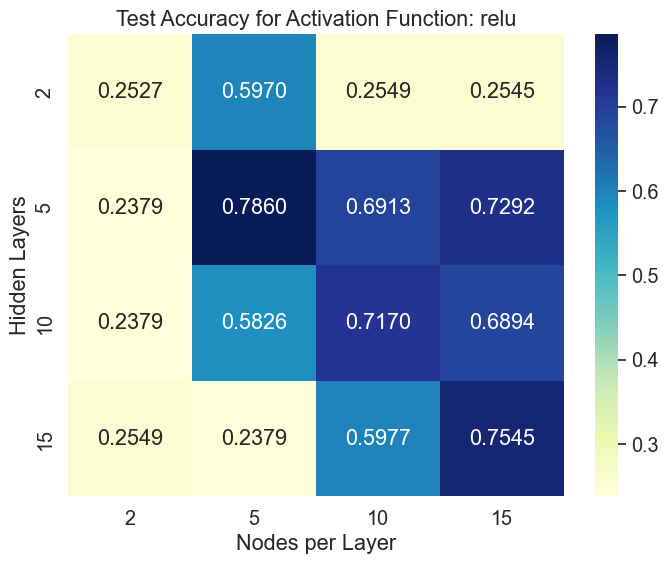

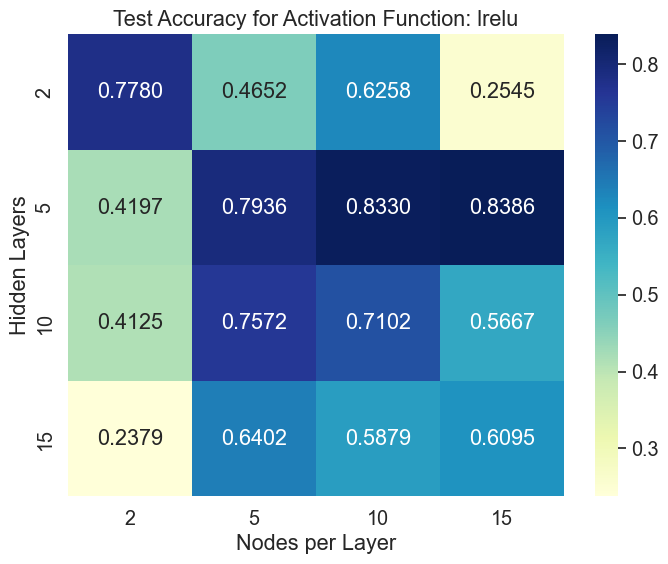

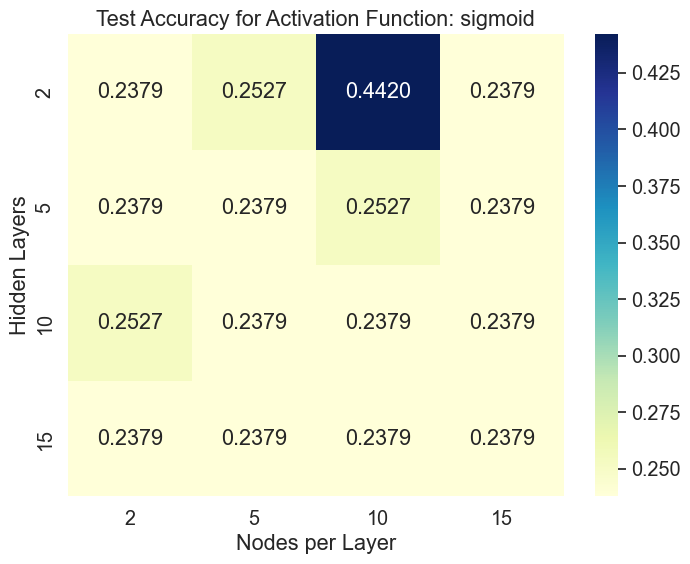

In [18]:
results_df = pd.DataFrame(results)

for activation in activations:
    pivot_table = results_df[results_df['Activation'] == activation].pivot_table(
        index="Hidden Layers", columns="Nodes", values="accuracy", aggfunc="mean")

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(f'Test Accuracy for Activation Function: {activation}')
    plt.xlabel('Nodes per Layer')
    plt.ylabel('Hidden Layers')
    plt.show()

### 2) Then, exploring different learning rates

In [19]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5]
epoch_options = [10, 50, 100]
activations = ['relu', 'lrelu', 'sigmoid']

num_hidden_layers = 5
num_of_nodes = 5

batch_size = 20

In [20]:
results = []

for activation in activations:
    for lr in learning_rates:
        for epochs in epoch_options:

            model = WeatherNN(input_dim=input_dim, hidden_dim=num_of_nodes, num_hidden_layers=num_hidden_layers, output_dim=num_classes, activation=activation)
            cost_function = nn.CrossEntropyLoss()

            for epoch in range(epochs):
                for X, y in train_loader:
                    training_loss = model.train(X, y, lr)
                
            correct = 0
            total = 0
            for X, y in test_loader:
                output = model.pred(X)
                test_pred = torch.argmax(output, dim=1)
                correct += (test_pred == y).sum().item()
                total += y.size(0)
            
            accuracy = correct / total

            print(f'Activation: {activation}, Learning Rate: {lr}, Test Accuracy: {accuracy:.4f}')

            results.append({
                'Activation': activation,
                'Epochs': epochs,
                'Learning Rate': lr,
                'accuracy': accuracy})

Activation: relu, Learning Rate: 0.0001, Test Accuracy: 0.2379
Activation: relu, Learning Rate: 0.0001, Test Accuracy: 0.2549
Activation: relu, Learning Rate: 0.0001, Test Accuracy: 0.7886
Activation: relu, Learning Rate: 0.001, Test Accuracy: 0.8080
Activation: relu, Learning Rate: 0.001, Test Accuracy: 0.2379
Activation: relu, Learning Rate: 0.001, Test Accuracy: 0.8064
Activation: relu, Learning Rate: 0.01, Test Accuracy: 0.2379
Activation: relu, Learning Rate: 0.01, Test Accuracy: 0.2379
Activation: relu, Learning Rate: 0.01, Test Accuracy: 0.2527
Activation: relu, Learning Rate: 0.1, Test Accuracy: 0.2545
Activation: relu, Learning Rate: 0.1, Test Accuracy: 0.2549
Activation: relu, Learning Rate: 0.1, Test Accuracy: 0.2549
Activation: relu, Learning Rate: 0.5, Test Accuracy: 0.2527
Activation: relu, Learning Rate: 0.5, Test Accuracy: 0.2549
Activation: relu, Learning Rate: 0.5, Test Accuracy: 0.2527
Activation: lrelu, Learning Rate: 0.0001, Test Accuracy: 0.5644
Activation: lrelu,

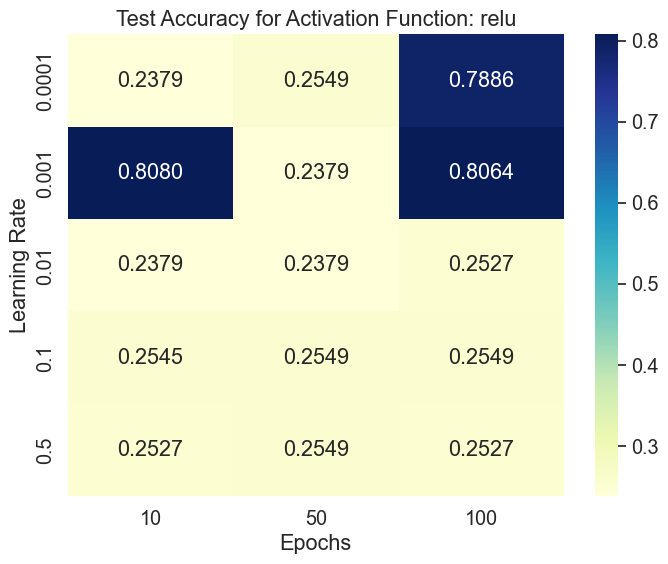

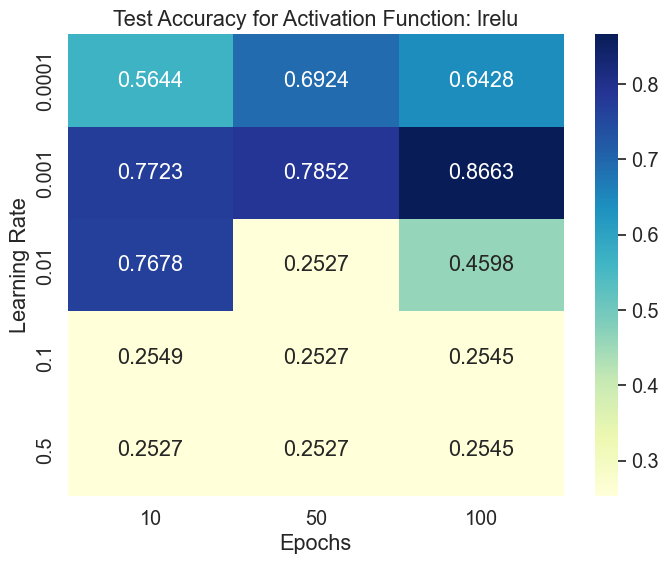

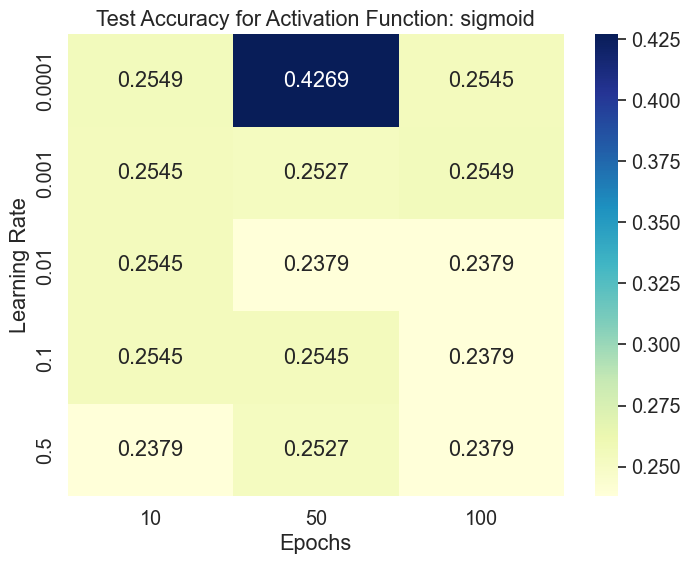

In [21]:
results_df = pd.DataFrame(results)
for activation in activations:
     pivot_table = results_df[results_df['Activation'] == activation].pivot_table(
         index="Learning Rate", columns="Epochs", values="accuracy", aggfunc="mean")

     plt.figure(figsize=(8, 6))
     sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
     plt.title(f'Test Accuracy for Activation Function: {activation}')
     plt.xlabel('Epochs')
     plt.ylabel('Learning Rate')
     plt.show()

## Weather type classification using our own NN

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
data = pd.read_csv(path)

# Identify categorical columns
cat_cols = data.select_dtypes(include=["object"]).columns

# Create label encoders for each categorical column
encoders = {col: LabelEncoder() for col in cat_cols}

# Apply encoding
# String to numerical conversion
for col in cat_cols:
    data[col] = encoders[col].fit_transform(data[col]).astype(int)

X = data.drop('Weather Type', axis=1).values
y = data['Weather Type'].values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
learning_rate = 0.001
activations = [RELU, LRELU, sigmoid]

num_hidden_layers = [2, 5, 10, 15]
num_of_nodes = [2, 5, 10, 15]

batch_size = 64
epochs = 10

results = []

for layers in num_hidden_layers:
    for activate in activations:

        activation_funcs = [activate] * layers + [identity]
        activation_ders  = [derivate(activate)] * layers + [derivate(identity)]

        nn = NeuralNetwork(
            network_input_size=X_train.shape[1],
            layer_output_sizes=[layers] + [1],
            activation_funcs=activation_funcs,
            activation_ders=activation_ders,
            cost_fun=cross_entropy,
            cost_der=cross_entropy_der
        )
        
        # Train network with stochastic gradient descent
        nn.train_SGD(X_train, y_train, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, optimizer="Adam")
        y_pred_test = nn._feed_forward(X_test)
        y_pred_train = nn._feed_forward(X_train)
        
        # Compute errors
        train_err = cross_entropy(y_pred_train, y_train)
        test_err  = cross_entropy(y_pred_test, y_test)
        
        results.append({
            "layers": layers,
            "activation": activate.__name__,
            "y_pred_test": y_pred_test,
            "y_pred_train": y_pred_train,
            "train_error": train_err,
            "test_error": test_err
        })

df = pd.DataFrame(results)

/Users/kjesta/Desktop/Masteremner/FYS-STK4155/Project_3_FYSSTK/Code/functions/cost_functions.py:7: RuntimeWarning: divide by zero encountered in divide
  return target/predict*(-1)
/Users/kjesta/Desktop/Masteremner/FYS-STK4155/Project_3_FYSSTK/Code/functions/cost_functions.py:7: RuntimeWarning: invalid value encountered in divide
  return target/predict*(-1)
/Users/kjesta/Desktop/Masteremner/FYS-STK4155/Project_3_FYSSTK/Code/functions/ffnn.py:110: RuntimeWarning: invalid value encountered in multiply
  dC_dz = dC_da * activation_der(z)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 50)